In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset


In [2]:
# Configurações
MODEL_NAME = "Adilmar/caramelo-smile-2"

BASE_DIR = os.path.dirname(os.path.abspath('.'))
DATASET_PATH = os.path.join(BASE_DIR, "fine-tuning", "avaliacoes_kabum_sentimento.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "fine-tuning", "caramelo-smile-kabum-finetuned")

In [3]:
# Carregar dados
df = pd.read_csv(DATASET_PATH)
print("Distribuição dos sentimentos:")
print(df['sentimento'].value_counts())

Distribuição dos sentimentos:
sentimento
positive    1787
neutral      127
negative      82
Name: count, dtype: int64


In [4]:
# Mapear sentimentos e converter para int
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentimento'].map(label_mapping)
df = df.dropna(subset=['label', 'avaliacao'])
df['avaliacao'] = df['avaliacao'].astype(str)
df['label'] = df['label'].astype(int)

print("Primeiras linhas do dataset processado:")
print(df[['avaliacao', 'sentimento', 'label']].head())

Primeiras linhas do dataset processado:
                                           avaliacao sentimento  label
0  Coolers com azul. Qualidade boa na embalagem e...   positive      2
1  Muito top a placa. Já veio com a bios atualiza...   positive      2
2               Bom. Bom produto, - Discreto, - Nada   positive      2
3  Acabamento perfeito. A memória é linda, materi...   positive      2
4  Cumpre a função. Ótimo produto e de fácil inst...   positive      2


In [5]:
# Dividir dados
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Treino: {len(train_df)}, Validação: {len(eval_df)}")
print("\nDistribuição no treino:")
print(train_df['sentimento'].value_counts())
print("\nDistribuição na validação:")
print(eval_df['sentimento'].value_counts())

Treino: 1596, Validação: 400

Distribuição no treino:
sentimento
positive    1429
neutral      101
negative      66
Name: count, dtype: int64

Distribuição na validação:
sentimento
positive    358
neutral      26
negative     16
Name: count, dtype: int64


In [6]:
# Carregar modelo
print("Carregando modelo e tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
print("Modelo e tokenizer carregados com sucesso!")

Carregando modelo e tokenizer...
Modelo e tokenizer carregados com sucesso!


In [7]:
# Tokenizar - forma mais simples e direta
def tokenize_function(examples):
    return tokenizer(
        examples["avaliacao"], 
        padding="max_length",
        truncation=True, 
        max_length=256
    )

In [8]:
# Criar datasets sem as colunas do pandas
train_dataset = Dataset.from_dict({
    "avaliacao": train_df['avaliacao'].tolist(),
    "label": train_df['label'].tolist()
})

eval_dataset = Dataset.from_dict({
    "avaliacao": eval_df['avaliacao'].tolist(),
    "label": eval_df['label'].tolist()
})

print("Datasets criados:")
print(f"Treino: {len(train_dataset)} exemplos")
print(f"Validação: {len(eval_dataset)} exemplos")

Datasets criados:
Treino: 1596 exemplos
Validação: 400 exemplos


In [9]:
# Tokenizar
print("Tokenizando datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)
print("Tokenização concluída!")

Tokenizando datasets...


Map:   0%|          | 0/1596 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenização concluída!


In [10]:
# Remover colunas originais
train_dataset = train_dataset.remove_columns(['avaliacao'])
eval_dataset = eval_dataset.remove_columns(['avaliacao'])

print("Estrutura final do dataset de treino:")
print(train_dataset)

Estrutura final do dataset de treino:
Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 1596
})


In [11]:
# Configurar treinamento
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=True,
)

print("Argumentos de treinamento configurados:")
print(f"- Épocas: {training_args.num_train_epochs}")
print(f"- Batch size: {training_args.per_device_train_batch_size}")
print(f"- Learning rate: {training_args.learning_rate}")
print(f"- Output dir: {training_args.output_dir}")

Argumentos de treinamento configurados:
- Épocas: 3
- Batch size: 8
- Learning rate: 2e-05
- Output dir: d:\VisualProjetos\tcc_sentiment-analysis-ecommerce\2_analise\fine-tuning\caramelo-smile-kabum-finetuned


In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [13]:
# Treinar
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

print("Trainer configurado com sucesso!")
print(f"Modelo: {type(model).__name__}")
print(f"Exemplos de treino: {len(train_dataset)}")
print(f"Exemplos de validação: {len(eval_dataset)}")

Trainer configurado com sucesso!
Modelo: RobertaForSequenceClassification
Exemplos de treino: 1596
Exemplos de validação: 400


In [14]:
print("Iniciando fine-tuning...")
train_history = trainer.train()
print("Fine-tuning concluído!")

Iniciando fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.343704,0.905000,0.884462
2,No log,0.347284,0.907500,0.894412
3,0.254400,0.360315,0.915000,0.907666


Fine-tuning concluído!


In [15]:
# Salvar modelo
trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modelo salvo em: {OUTPUT_DIR}")

Modelo salvo em: d:\VisualProjetos\tcc_sentiment-analysis-ecommerce\2_analise\fine-tuning\caramelo-smile-kabum-finetuned


In [16]:
# Avaliar
results = trainer.evaluate()
print("\n=== RESULTADOS FINAIS ===")
print(f"Acurácia: {results['eval_accuracy']:.4f}")
print(f"F1-Score: {results['eval_f1']:.4f}")
print(f"Loss: {results['eval_loss']:.4f}")


=== RESULTADOS FINAIS ===
Acurácia: 0.9150
F1-Score: 0.9077
Loss: 0.3603


In [17]:
# Testar
classifier = pipeline("sentiment-analysis", model=OUTPUT_DIR, tokenizer=OUTPUT_DIR)

test_samples = [
    "Produto excelente, chegou rápido e funcionando perfeitamente!",
    "Não gostei, veio com defeito e o suporte foi péssimo.",
    "O produto é ok, mas a entrega atrasou um pouco.",
]

print("\n=== TESTES COM NOVOS TEXTOS ===")
for sample in test_samples:
    result = classifier(sample)[0]
    print(f"Texto: {sample}")
    print(f"Sentimento: {result['label']} (Score: {result['score']:.4f})")
    print("-" * 50)

Device set to use cuda:0



=== TESTES COM NOVOS TEXTOS ===
Texto: Produto excelente, chegou rápido e funcionando perfeitamente!
Sentimento: positive (Score: 0.9982)
--------------------------------------------------
Texto: Não gostei, veio com defeito e o suporte foi péssimo.
Sentimento: negative (Score: 0.9855)
--------------------------------------------------
Texto: O produto é ok, mas a entrega atrasou um pouco.
Sentimento: neutral (Score: 0.9647)
--------------------------------------------------


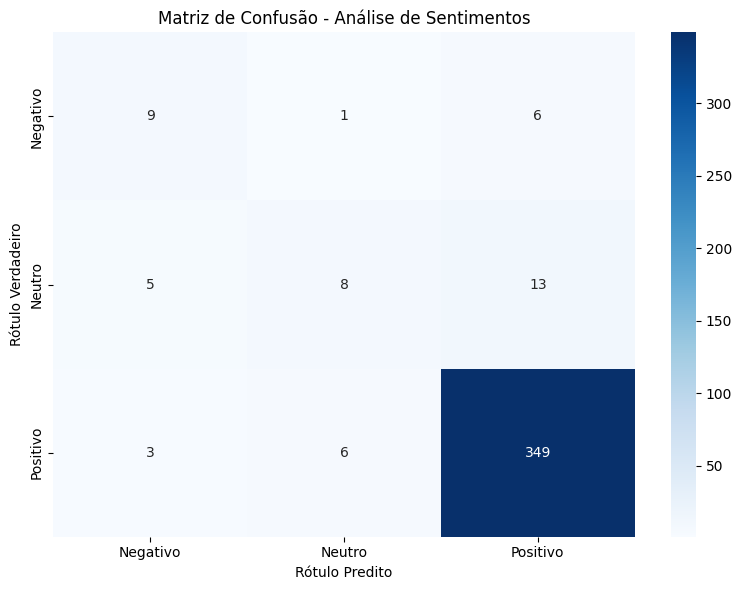


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

    Negativo       0.53      0.56      0.55        16
      Neutro       0.53      0.31      0.39        26
    Positivo       0.95      0.97      0.96       358

    accuracy                           0.92       400
   macro avg       0.67      0.62      0.63       400
weighted avg       0.90      0.92      0.91       400



In [18]:
# Obter as predições do modelo no conjunto de validação
predictions_output = trainer.predict(eval_dataset)
predictions = predictions_output.predictions
predicted_labels = np.argmax(predictions, axis=1)
true_labels = predictions_output.label_ids

# Definir os nomes das classes
# mapeamento foi: {'negative': 0, 'neutral': 1, 'positive': 2}
class_names = ['Negativo', 'Neutro', 'Positivo']

# Gerar a Matriz de Confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Calcular porcentagens
# Normaliza por linha (true label) para ver onde o modelo confunde cada classe
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotar a Matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Matriz de Confusão - Análise de Sentimentos')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.tight_layout()
plt.show()

# Imprimir o Relatório de Classificação Detalhado
from sklearn.metrics import classification_report
print("\nRelatório de Classificação Detalhado:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))